# Part 5: Instruction Tuning
## From text completion to following instructions

In Parts 1-4, we built models that complete text. Give them a prompt, they continue it. But that's not how we use ChatGPT or Claude:

**Pretrained model**:
```
Input: "What is the capital of France?"
Output: "What is the capital of Germany? What is the capital of Spain?..."
```

**Instruction-tuned model**:
```
Input: "What is the capital of France?"
Output: "Paris"
```

The pretrained model doesn't know it should **answer** the question—it just continues the text pattern.

## What is Instruction Tuning?

Instruction tuning (also called supervised fine-tuning or SFT) teaches the model to:

1. Recognize that an input is a question/instruction
2. Generate an appropriate response
3. Stop after answering

We do this by fine-tuning on (instruction, response) pairs.

## Setup

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import math
import os
import requests
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

%config InlineBackend.figure_format = 'retina'


Using device: cuda


## Step 1: Create an Instruction Dataset

For a real model, we'd use datasets like Alpaca, Dolly, or OpenAssistant. For our educational purposes, we'll create a small synthetic dataset.

In [2]:
# Our expanded instruction dataset with Python Q&A
instruction_data = [
    # === GENERAL Q&A ===
    {"instruction": "What is the capital of France?", "response": "The capital of France is Paris."},
    {"instruction": "What is the capital of India?", "response": "The capital of India is New Delhi."},
    {"instruction": "What is the capital of Japan?", "response": "The capital of Japan is Tokyo."},
    {"instruction": "What is the capital of Germany?", "response": "The capital of Germany is Berlin."},
    {"instruction": "What is the capital of Italy?", "response": "The capital of Italy is Rome."},
    {"instruction": "What is the capital of Spain?", "response": "The capital of Spain is Madrid."},
    {"instruction": "What is the capital of China?", "response": "The capital of China is Beijing."},
    {"instruction": "What is the capital of Brazil?", "response": "The capital of Brazil is Brasilia."},
    
    # Math
    {"instruction": "What is 2 + 2?", "response": "2 + 2 equals 4."},
    {"instruction": "What is 5 * 3?", "response": "5 * 3 equals 15."},
    {"instruction": "What is 10 - 7?", "response": "10 - 7 equals 3."},
    {"instruction": "What is 20 / 4?", "response": "20 / 4 equals 5."},
    {"instruction": "What is 3 + 3?", "response": "3 + 3 equals 6."},
    {"instruction": "What is 7 * 8?", "response": "7 * 8 equals 56."},
    {"instruction": "What is 100 / 10?", "response": "100 / 10 equals 10."},
    
    # Basic instructions
    {"instruction": "Say hello.", "response": "Hello! How can I help you today?"},
    {"instruction": "Count to five.", "response": "1, 2, 3, 4, 5."},
    {"instruction": "Count to three.", "response": "1, 2, 3."},
    {"instruction": "Name three colors.", "response": "Red, blue, and green."},
    {"instruction": "List three fruits.", "response": "Apple, banana, and orange."},
    {"instruction": "Name three animals.", "response": "Dog, cat, and elephant."},
    {"instruction": "List three countries.", "response": "USA, India, and Japan."},
    
    # General knowledge
    {"instruction": "Who wrote Romeo and Juliet?", "response": "William Shakespeare wrote Romeo and Juliet."},
    {"instruction": "What planet is closest to the sun?", "response": "Mercury is the planet closest to the sun."},
    {"instruction": "How many days are in a week?", "response": "There are 7 days in a week."},
    {"instruction": "What is H2O?", "response": "H2O is the chemical formula for water."},
    {"instruction": "How many hours in a day?", "response": "There are 24 hours in a day."},
    {"instruction": "How many months in a year?", "response": "There are 12 months in a year."},
    
    # === PYTHON BASICS ===
    {"instruction": "What is Python?", "response": "Python is a popular programming language known for its simplicity and readability."},
    {"instruction": "How do I print Hello World in Python?", "response": "Use print('Hello World') to print Hello World in Python."},
    {"instruction": "What is a variable in Python?", "response": "A variable is a name that stores a value. Example: x = 5 stores 5 in x."},
    {"instruction": "How do I create a list in Python?", "response": "Create a list with square brackets: my_list = [1, 2, 3]"},
    {"instruction": "What is a function in Python?", "response": "A function is reusable code defined with def. Example: def greet(): print('Hi')"},
    {"instruction": "How do I define a function in Python?", "response": "Use def keyword: def my_function(): followed by indented code."},
    {"instruction": "What is a loop in Python?", "response": "A loop repeats code. Use for to iterate: for i in range(5): print(i)"},
    {"instruction": "How do I use a for loop?", "response": "for item in collection: then indented code. Example: for i in range(3): print(i)"},
    {"instruction": "What is an if statement?", "response": "An if statement runs code conditionally: if x > 5: print('big')"},
    {"instruction": "How do I check if a number is even?", "response": "Use modulo: if num % 2 == 0: the number is even."},
    {"instruction": "What is a string in Python?", "response": "A string is text in quotes: name = 'Python' or name = \"Python\""},
    {"instruction": "How do I get the length of a list?", "response": "Use len(): length = len(my_list) returns the number of items."},
    {"instruction": "What is a dictionary in Python?", "response": "A dictionary stores key-value pairs: d = {'name': 'John', 'age': 25}"},
    {"instruction": "How do I add to a list?", "response": "Use append(): my_list.append(4) adds 4 to the end of my_list."},
    {"instruction": "What is range() in Python?", "response": "range(n) generates numbers 0 to n-1. range(5) gives 0,1,2,3,4."},
    {"instruction": "How do I read a file in Python?", "response": "Use open(): with open('file.txt', 'r') as f: content = f.read()"},
    {"instruction": "What is a class in Python?", "response": "A class is a blueprint for objects: class Dog: def bark(self): print('Woof')"},
    {"instruction": "How do I handle errors in Python?", "response": "Use try/except: try: risky_code() except: handle_error()"},
    {"instruction": "What is None in Python?", "response": "None represents no value or null. Example: x = None"},
    {"instruction": "How do I convert string to int?", "response": "Use int(): num = int('42') converts string '42' to integer 42."},
    {"instruction": "What is a tuple in Python?", "response": "A tuple is immutable list: t = (1, 2, 3) cannot be changed after creation."},
    {"instruction": "How do I join strings?", "response": "Use + or join: 'Hello' + ' World' or ' '.join(['Hello', 'World'])"},
    {"instruction": "What is import in Python?", "response": "import loads a module: import math then use math.sqrt(16) for square root."},
    {"instruction": "How do I create a set?", "response": "Use curly braces: s = {1, 2, 3} creates a set with unique values."},
    {"instruction": "What is self in Python?", "response": "self refers to the current object instance in a class method."},
    {"instruction": "How do I reverse a list?", "response": "Use reverse() method: my_list.reverse() or my_list[::-1] for new list."},
    {"instruction": "What is pip?", "response": "pip is Python's package manager. Use pip install package_name to install."},
    {"instruction": "How do I check Python version?", "response": "Run python --version in terminal or import sys; print(sys.version)"},
    {"instruction": "What is a boolean?", "response": "Boolean is True or False. Used in conditions: if is_valid: do_something()"},
    {"instruction": "How do I sort a list?", "response": "Use sort(): my_list.sort() or sorted(my_list) for new sorted list."},
    
    # === PYTHON DATA TYPES ===
    {"instruction": "What data types exist in Python?", "response": "Python has int, float, str, list, dict, tuple, set, bool, and None."},
    {"instruction": "What is the difference between list and tuple?", "response": "Lists are mutable (changeable), tuples are immutable (fixed after creation)."},
    {"instruction": "How do I check type of a variable?", "response": "Use type(): type(x) returns the type, like <class 'int'> or <class 'str'>"},
    {"instruction": "What is a float in Python?", "response": "A float is a decimal number: x = 3.14 or y = 2.0"},
    
    # === ALGORITHMS ===
    {"instruction": "What is an algorithm?", "response": "An algorithm is a step-by-step procedure for solving a problem or task."},
    {"instruction": "What is Big O notation?", "response": "Big O describes algorithm efficiency. O(1) is constant, O(n) is linear time."},
    {"instruction": "What is a sorting algorithm?", "response": "A sorting algorithm arranges items in order. Examples: bubble sort, quicksort."},
    {"instruction": "What is recursion?", "response": "Recursion is when a function calls itself. Needs a base case to stop."},
    {"instruction": "What is binary search?", "response": "Binary search finds items in sorted list by halving. O(log n) time."},
    
    # === MACHINE LEARNING ===
    {"instruction": "What is machine learning?", "response": "Machine learning is AI where computers learn patterns from data to make predictions."},
    {"instruction": "What is deep learning?", "response": "Deep learning uses neural networks with many layers to learn complex patterns."},
    {"instruction": "What is a neural network?", "response": "A neural network is layers of connected nodes that learn from data."},
    {"instruction": "What is training in ML?", "response": "Training is teaching a model by showing it examples and adjusting weights."},
    {"instruction": "What is overfitting?", "response": "Overfitting is when a model memorizes training data but fails on new data."},
    {"instruction": "What is a loss function?", "response": "A loss function measures how wrong predictions are. Training minimizes it."},
    {"instruction": "What is PyTorch?", "response": "PyTorch is a Python library for deep learning with dynamic computation graphs."},
    {"instruction": "What is a tensor?", "response": "A tensor is a multi-dimensional array, like a matrix but with more dimensions."},
    {"instruction": "What is backpropagation?", "response": "Backpropagation computes gradients to update weights during training."},
    {"instruction": "What is a learning rate?", "response": "Learning rate controls how much to adjust weights. Too high = unstable, too low = slow."},
]

print(f"Number of instruction-response pairs: {len(instruction_data)}")
print(f"Categories covered: General Q&A, Math, Python basics, Data types, Algorithms, ML")

Number of instruction-response pairs: 77
Categories covered: General Q&A, Math, Python basics, Data types, Algorithms, ML


## Step 2: Format for Training

We need a consistent format that the model can learn. A common format is:

```
### Instruction:
{instruction}

### Response:
{response}<|endoftext|>
```

In [3]:
def format_example(example):
    """Format an instruction-response pair for training."""
    return f"""### Instruction:
{example['instruction']}

### Response:
{example['response']}<|endoftext|>"""

# Preview formatting
print("Example formatted training data:")
print("=" * 50)
print(format_example(instruction_data[0]))
print("=" * 50)
print(format_example(instruction_data[5]))

Example formatted training data:
### Instruction:
What is the capital of France?

### Response:
The capital of France is Paris.<|endoftext|>
### Instruction:
What is the capital of Spain?

### Response:
The capital of Spain is Madrid.<|endoftext|>


In [4]:
# Create training text
training_text = "\n\n".join(format_example(ex) for ex in instruction_data)
print(f"Total training characters: {len(training_text)}")
print(f"\nFirst 500 characters:")
print(training_text[:500])

Total training characters: 9646

First 500 characters:
### Instruction:
What is the capital of France?

### Response:
The capital of France is Paris.<|endoftext|>

### Instruction:
What is the capital of India?

### Response:
The capital of India is New Delhi.<|endoftext|>

### Instruction:
What is the capital of Japan?

### Response:
The capital of Japan is Tokyo.<|endoftext|>

### Instruction:
What is the capital of Germany?

### Response:
The capital of Germany is Berlin.<|endoftext|>

### Instruction:
What is the capital of Italy?

### Response:


## Step 3: Build Vocabulary and Dataset

In [5]:
# Build vocabulary from training data
chars = sorted(set(training_text))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)

print(f"Vocabulary size: {vocab_size}")
print(f"Characters: {''.join(chars[:50])}...")

Vocabulary size: 82
Characters: 
 !"#%'()*+,-./012345678:;<=>?ABCDEFGHIJLMNOPRSTUW...


In [6]:
# Encode training data with SMALLER block size
block_size = 64  # Reduced from 128 for speed

def build_dataset(text, block_size, stoi):
    data = [stoi[ch] for ch in text]
    X, Y = [], []
    for i in range(len(data) - block_size):
        X.append(data[i:i + block_size])
        Y.append(data[i + 1:i + block_size + 1])
    return torch.tensor(X), torch.tensor(Y)

X, Y = build_dataset(training_text, block_size, stoi)
print(f"Training examples: {len(X)} (small block size for fast demo)")

Training examples: 9582 (small block size for fast demo)


## Step 4: Model Architecture

We'll use the transformer from Part 4, but with a twist: we'll initialize with pretrained weights in a real scenario. For simplicity, we'll train from scratch on our small dataset.

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.shape[1]]


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.W_qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.W_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        batch, seq_len, d_model = x.shape
        qkv = self.W_qkv(x).reshape(batch, seq_len, 3, self.n_heads, self.d_k)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        Q, K, V = qkv[0], qkv[1], qkv[2]

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float('-inf'))

        attention = F.softmax(scores, dim=-1)
        output = torch.matmul(attention, V)
        output = output.permute(0, 2, 1, 3).reshape(batch, seq_len, d_model)
        return self.W_out(output)


class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attention(self.ln1(x)))
        x = x + self.ffn(self.ln2(x))
        return x


class InstructionLM(nn.Module):
    """Transformer for instruction following."""

    def __init__(self, vocab_size, d_model, n_heads, n_layers, block_size, dropout=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, block_size)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, dropout)
            for _ in range(n_layers)
        ])
        self.ln_final = nn.LayerNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        x = self.token_emb(x)
        x = self.pos_enc(x)
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.ln_final(x)
        return self.output(x)

In [8]:
# Create model with REDUCED capacity for fast demo
d_model = 128     # Reduced from 256
n_heads = 4       # Reduced from 8
n_layers = 3      # Reduced from 6

model = InstructionLM(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    block_size=block_size,
    dropout=0.1
).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,}")

# Model scale context
print(f"\n--- Model Scale Context ---")
print(f"Our model:     ~{num_params/1_000_000:.1f}M parameters (SMALL for fast demo!)")
print(f"GPT-2 Small:   124M parameters  ({124_000_000/num_params:.0f}x larger)")
print(f"LLaMA-7B:      7B parameters    ({7_000_000_000/num_params:.0f}x larger)")
print(f"Claude/GPT-4:  ~1T+ parameters  ({1_000_000_000_000/num_params:.0f}x larger)")

Model parameters: 614,610

--- Model Scale Context ---
Our model:     ~0.6M parameters (SMALL for fast demo!)
GPT-2 Small:   124M parameters  (202x larger)
LLaMA-7B:      7B parameters    (11389x larger)
Claude/GPT-4:  ~1T+ parameters  (1627048x larger)


## Step 5: Training

In [9]:
def train(model, X, Y, epochs=1000, batch_size=32, lr=3e-4, checkpoint_path='../models/checkpoint_part5.pt', resume=True):
    """
    Resumable training with checkpoint saving.
    
    Args:
        resume: If True, attempts to resume from checkpoint
        checkpoint_path: Path to save/load checkpoints
    """
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    X, Y = X.to(device), Y.to(device)
    losses = []
    start_epoch = 0

    # Try to resume from checkpoint
    if resume and os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        losses = checkpoint['losses']
        print(f"Resumed from epoch {start_epoch}, previous loss: {losses[-1]:.4f}")

    for epoch in range(start_epoch, epochs):
        perm = torch.randperm(X.shape[0])
        total_loss, n_batches = 0, 0

        for i in range(0, len(X), batch_size):
            idx = perm[i:i+batch_size]
            x_batch, y_batch = X[idx], Y[idx]

            logits = model(x_batch)
            loss = F.cross_entropy(logits.view(-1, vocab_size), y_batch.view(-1))

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        losses.append(total_loss / n_batches)
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {losses[-1]:.4f}")
        
        # Save checkpoint every 25 epochs
        if (epoch + 1) % 25 == 0:
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses': losses,
            }, checkpoint_path)

    print(f"Training complete! Final loss: {losses[-1]:.4f}")
    return losses

# Educational note: 100 epochs on small model for fast demo
# For production: use larger model and 1000+ epochs
# Training is resumable - interrupt and re-run this cell to continue!
print("Training is resumable - you can interrupt and restart!")
losses = train(model, X, Y, epochs=25, batch_size=64, lr=1e-3)

Training is resumable - you can interrupt and restart!
Resuming from checkpoint: ../models/checkpoint_part5.pt
Resumed from epoch 25, previous loss: 0.1294
Training complete! Final loss: 0.1294


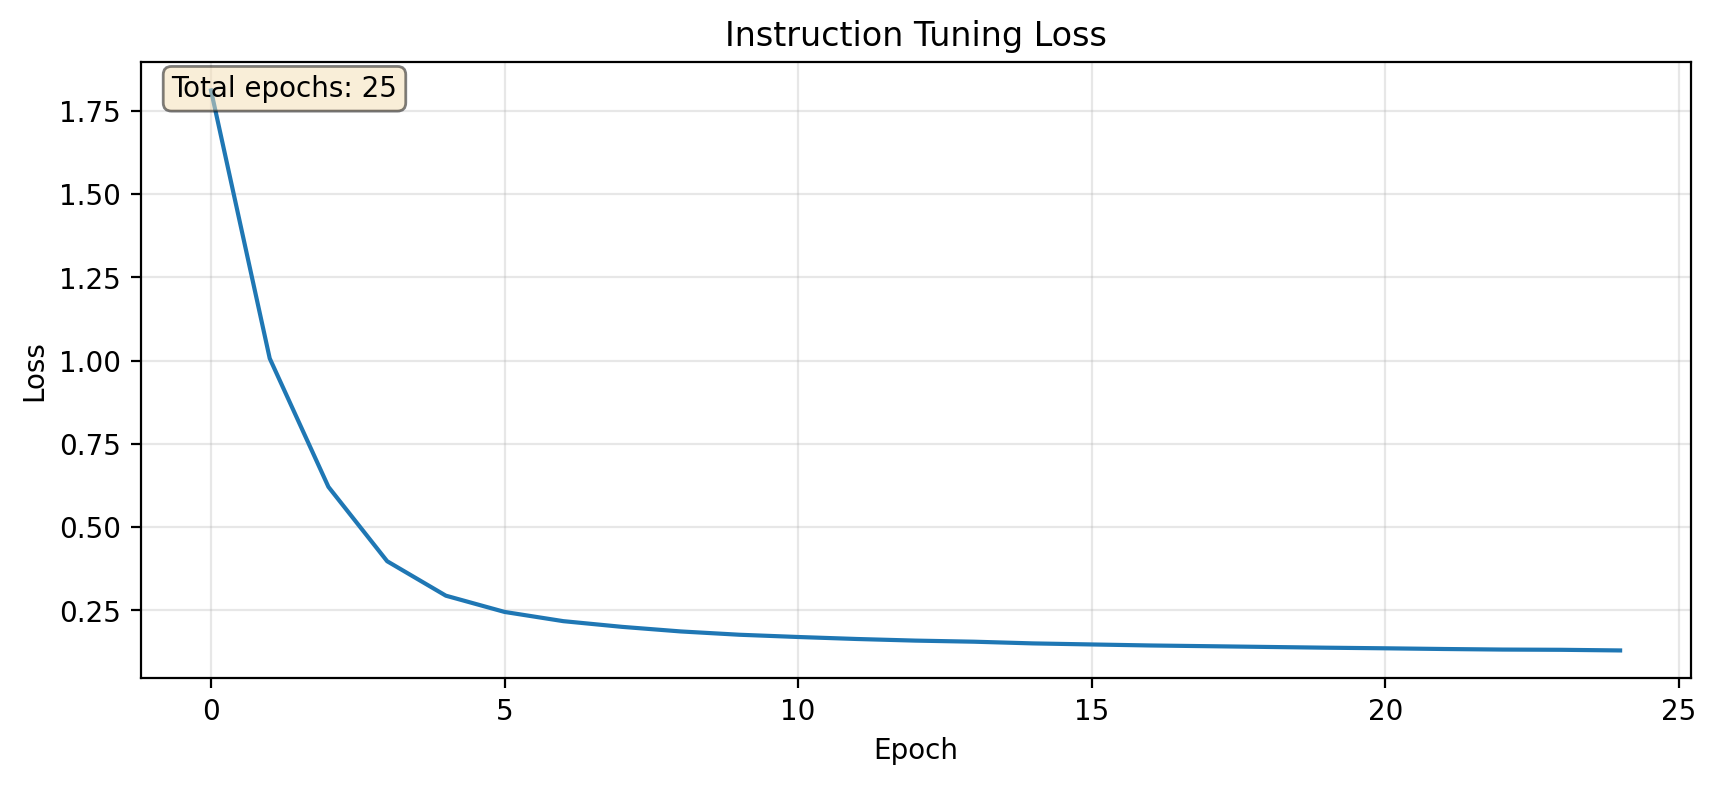

Training summary: 25 epochs completed, final loss: 0.1294


In [10]:
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Instruction Tuning Loss')
plt.grid(True, alpha=0.3)
# Show number of epochs trained
plt.text(0.02, 0.98, f'Total epochs: {len(losses)}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

print(f"Training summary: {len(losses)} epochs completed, final loss: {losses[-1]:.4f}")

## Step 6: Inference with Instructions

In [11]:
@torch.no_grad()
def ask(model, instruction, max_tokens=100, temperature=0.7):
    """
    Ask the model a question in instruction format.
    """
    model.eval()

    # Format the prompt
    prompt = f"""### Instruction:
{instruction}

### Response:
"""

    # Encode prompt
    tokens = [stoi.get(ch, 0) for ch in prompt]
    generated = list(prompt)

    for _ in range(max_tokens):
        # Use last block_size tokens
        context = tokens[-block_size:] if len(tokens) >= block_size else tokens
        x = torch.tensor([context]).to(device)

        logits = model(x)
        logits = logits[0, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, 1).item()

        next_char = itos[next_idx]
        tokens.append(next_idx)
        generated.append(next_char)

        # Stop at end-of-text token or double newline
        if '<|endoftext|>' in ''.join(generated[-15:]):
            break

    response = ''.join(generated)

    # Extract just the response part
    if "### Response:" in response:
        response = response.split("### Response:")[-1].strip()
        response = response.replace("<|endoftext|>", "").strip()

    return response

In [12]:
# Test with training examples - diverse categories
print("=" * 60)
print("TESTING ON TRAINING EXAMPLES")
print("=" * 60)

test_questions = [
    # General Q&A
    "What is the capital of France?",
    "What is 2 + 2?",
    "Who wrote Romeo and Juliet?",
    "Say hello.",
    
    # Python questions
    "What is Python?",
    "How do I print Hello World in Python?",
    "What is a list in Python?",
    "What is a for loop?",
    
    # Algorithms
    "What is Big O notation?",
    "What is recursion?",
]

for q in test_questions:
    print(f"\nQ: {q}")
    print(f"A: {ask(model, q)}")

TESTING ON TRAINING EXAMPLES

Q: What is the capital of France?
A: The capital of France is Paris.

Q: What is 2 + 2?
A: 2 + 2 equals 4.

Q: Who wrote Romeo and Juliet?
A: William Shakespeare wrote Romeo and Juliet.

Q: Say hello.
A: Hello! How can I help you today?

Q: What is Python?
A: Python is a popular programming language known for its simplicity and readability.

Q: How do I print Hello World in Python?
A: Use print('Hello World') to print Hello World in Python.

Q: What is a list in Python?
A: A tensor is a multi-dimensional array, like a matrix but with more dimensions.

Q: What is a for loop?
A: for item in collection: then indented code. Example: for i in range(3): print(i)

Q: What is Big O notation?
A: Big O describes algorithm effficiency. O(1) is constant, O(n) is linear time.

Q: What is recursion?
A: Recursion is when a function calls itself. Needs a base case to stop.


In [13]:
# Test generalization (these weren't in training!)
print("\n" + "=" * 60)
print("TESTING GENERALIZATION (not in training)")
print("=" * 60)

novel_questions = [
    # Similar patterns to training data
    "What is the capital of Spain?",  # Similar to other capitals
    "What is 3 + 3?",                  # Similar to other math
    "Count to three.",                 # Similar to "Count to five"
    
    # Python variations
    "What is a dictionary?",           # Simil to other data structures
    "What is machine learning?",       # Seen in training
    
    # Harder generalization
    "Name three animals.",             # Similar to "Name three colors"
    "What is 5 + 5?",                  # Math pattern
]

for q in novel_questions:
    print(f"\nQ: {q}")
    print(f"A: {ask(model, q)}")


TESTING GENERALIZATION (not in training)

Q: What is the capital of Spain?
A: The capital of Spain is Madrid.

Q: What is 3 + 3?
A: 3 + 3 equals 6.

Q: Count to three.
A: 1, 2, 3.

Q: What is a dictionary?
A: A sorting algorithm arranges items in order. Examples: bubbble sort, quicksort.

Q: What is machine learning?
A: Machine learning is AI where computers learn patterns from data to make predictions.

Q: Name three animals.
A: Dog, cat, and elephant.

Q: What is 5 + 5?
A: 5 * 3 equals 15.


### Generalization Limits

With only 20 training examples, generalization is limited. Real instruction-tuned models like Alpaca use 52K examples, and models like GPT-3.5 use millions.

However, even with few examples, the model learns the **format**: instruction → response pattern.

## Step 7: Understanding What Changed

The key insight: **instruction tuning doesn't add new knowledge**—it teaches the model to **access and format** its knowledge appropriately.

In [14]:
# Let's see what happens WITHOUT instruction format
@torch.no_grad()
def complete(model, prompt, max_tokens=100, temperature=0.7):
    """Raw text completion without instruction formatting."""
    model.eval()

    tokens = [stoi.get(ch, 0) for ch in prompt]
    generated = list(prompt)

    for _ in range(max_tokens):
        context = tokens[-block_size:]
        x = torch.tensor([context]).to(device)

        logits = model(x)[0, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, 1).item()

        tokens.append(next_idx)
        generated.append(itos[next_idx])

    return ''.join(generated)

print("Raw completion (no instruction format):")
print("-" * 50)
print(complete(model, "What is the capital of France?", max_tokens=80))

Raw completion (no instruction format):
--------------------------------------------------
What is the capital of France?

### Response:
The capital of France is Paris.<|endoftext|>

### Instruction:
W


With instruction format, the model knows to:
1. Look for "### Instruction:" marker
2. Generate a direct response after "### Response:"
3. Stop at the end-of-text token

## Save Model for Later Use

Export the instruction-tuned model for use in Part 6 (DPO) and for inference.

In [15]:
import os

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save model checkpoint with architecture info
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'vocab_size': vocab_size,
        'd_model': d_model,
        'n_heads': n_heads,
        'n_layers': n_layers,
        'block_size': block_size,
    },
    'stoi': stoi,
    'itos': itos,
    'final_loss': losses[-1] if losses else None,
}

torch.save(checkpoint, '../models/instruction_tuned.pt')
print(f"Model saved to ../models/instruction_tuned.pt")

# Verify
loaded = torch.load('../models/instruction_tuned.pt', weights_only=False)
print(f"Model config: {loaded['model_config']}")
print(f"Model parameters: {num_params:,}")

Model saved to ../models/instruction_tuned.pt
Model config: {'vocab_size': 82, 'd_model': 128, 'n_heads': 4, 'n_layers': 3, 'block_size': 64}
Model parameters: 614,610


## Clean Up GPU Memory

In [16]:
import gc

# Delete model and data tensors
del model
del X, Y

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

gc.collect()

print("GPU memory cleared!")
if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")

GPU memory cleared!
GPU memory allocated: 12.9 MB
GPU memory cached: 26.0 MB


## The Real-World Instruction Tuning Pipeline

```
┌─────────────────────────────────────────────────────────────┐
│                 INSTRUCTION TUNING PIPELINE                  │
└─────────────────────────────────────────────────────────────┘

1. PRETRAIN on massive text corpus
   └── Model learns language patterns, facts, reasoning

2. COLLECT instruction data
   ├── Human-written (expensive, high quality)
   ├── GPT-generated (Alpaca approach)
   └── From existing NLP datasets

3. FORMAT data consistently
   └── Instruction: {task}
       Response: {answer}

4. FINE-TUNE on instruction data
   ├── Usually 1-3 epochs
   ├── Lower learning rate than pretraining
   └── Careful not to forget pretrained knowledge

5. EVALUATE
   ├── Held-out instructions
   ├── Human evaluation
   └── Benchmark tasks
```

## Summary

We implemented instruction tuning from scratch:

| Aspect | What We Did |
|--------|-------------|
| Dataset | 20 instruction-response pairs |
| Format | "### Instruction:\n{q}\n\n### Response:\n{a}" |
| Model | Same transformer from Part 4 |
| Training | Standard next-token prediction |
| Result | Model follows instruction format |

**Key insight**: Instruction tuning is just supervised fine-tuning on carefully formatted data. The magic is in the data, not the training procedure.

## What's Next

In **Part 6**, we'll add **DPO (Direct Preference Optimization)**—training the model to prefer good responses over bad ones. This is the final step toward alignment.

## Exercises

1. **More data**: Add 50 more instruction-response pairs. How does quality improve?
2. **Different formats**: Try "User: {q}\nAssistant: {a}" format
3. **Multi-turn**: Add conversation examples with multiple turns
4. **Negative examples**: What if you include bad examples? (Spoiler: Part 6!)
5. **LoRA**: Implement low-rank adaptation for efficient fine-tuning